In [1]:
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

## 创建输入数据

In [2]:
NUM_CLASSES = 10

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.npz')

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print("x_train.shape = {}, y_train.shape = {}".format(x_train.shape, y_train.shape))
print("x_test.shape = {}, y_test.shape = {}".format(x_test.shape, y_test.shape))

x_train.shape = (60000, 28, 28, 1), y_train.shape = (60000, 10)
x_test.shape = (10000, 28, 28, 1), y_test.shape = (10000, 10)


## 定义网络

In [4]:
inputs = Input(shape=(28, 28, 1), name='input')

x = keras.layers.SeparableConv2D(24, kernel_size=(6, 6), strides=1)(inputs)
x = BatchNormalization(scale=False, beta_initializer=Constant(0.01))(x)
x = Activation('relu')(x)
x = Dropout(rate=0.25)(x)

x = keras.layers.SeparableConv2D(48, kernel_size=(5, 5), strides=2)(x)
x = BatchNormalization(scale=False, beta_initializer=Constant(0.01))(x)
x = Activation('relu')(x)
x = Dropout(rate=0.25)(x)

x = keras.layers.SeparableConv2D(64, kernel_size=(4, 4), strides=2)(x)
x = BatchNormalization(scale=False, beta_initializer=Constant(0.01))(x)
x = Activation('relu')(x)
x = Dropout(rate=0.25)(x)

x = Flatten()(x)
x = Dense(200)(x)
x = BatchNormalization(scale=False, beta_initializer=Constant(0.01))(x)
x = Activation('relu')(x)
x = Dropout(rate=0.25)(x)

predications = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model = Model(inputs=inputs, outputs=predications)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 23, 23, 24)        84        
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 24)        72        
_________________________________________________________________
activation (Activation)      (None, 23, 23, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 24)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 10, 10, 48)        1800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 48)        144   

In [6]:
lr_decay = lambda epoch: 0.0001 + 0.02 * math.pow(1.0 / math.e, epoch / 3.0)
decay_callback = LearningRateScheduler(lr_decay, verbose=1)

history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, 
                    validation_data=(x_test, y_test), callbacks=[decay_callback])

Train on 60000 samples, validate on 10000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0201.
Epoch 1/20
60000/60000 [==============================] - 15s 256us/sample - loss: 0.1990 - accuracy: 0.9377 - val_loss: 0.1646 - val_accuracy: 0.9541

Epoch 00002: LearningRateScheduler reducing learning rate to 0.014430626211475785.
Epoch 2/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0843 - accuracy: 0.9735 - val_loss: 0.0390 - val_accuracy: 0.9872

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01036834238065184.
Epoch 3/20
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0634 - accuracy: 0.9808 - val_loss: 0.0286 - val_accuracy: 0.9899

Epoch 00004: LearningRateScheduler reducing learning rate to 0.007457588823428847.
Epoch 4/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0479 - accuracy: 0.9849 - val_loss: 0.0261 - val_accuracy: 0.9914

Epoch 00005: LearningRateSched

## 绘制 AUC 图

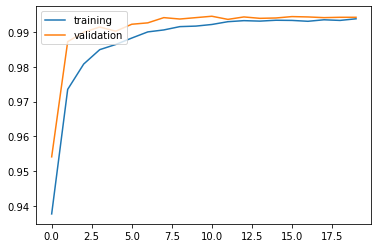

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [8]:
import numpy as np
print(history.history['accuracy'], "\n\nThe Best train_AC is: ", np.max(history.history['accuracy']))

[0.9377, 0.9734833, 0.98076665, 0.9849, 0.9863833, 0.9882333, 0.99, 0.9905667, 0.99151665, 0.9916667, 0.9921333, 0.99293333, 0.9932333, 0.9931, 0.99335, 0.9933, 0.99305, 0.9934833, 0.9933, 0.99376667] 

The Best train_AC is:  0.99376667


In [10]:
print(history.history['val_accuracy'], "\n\nThe Best val_AC is: ", np.max(history.history['val_accuracy']))

[0.9541, 0.9872, 0.9899, 0.9914, 0.9902, 0.9922, 0.9926, 0.9941, 0.9937, 0.9941, 0.9945, 0.9936, 0.9943, 0.9939, 0.994, 0.9944, 0.9943, 0.9941, 0.9942, 0.9942] 

The Best val_AC is:  0.9945


## 评估模型

In [13]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 125us/sample - loss: 0.0178 - accuracy: 0.9942
Test loss: 0.017834317178014498
Test accuracy: 0.9942


## 保存模型原始模型

In [17]:
print('Saving model to...')
model.save('SeparableMnist.h5')
print('finish save')

Saving model to...
finish save


# 转换模型

## 加载模型

In [18]:
net = tf.keras.models.load_model('SeparableMnist.h5')

## 转换模型

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(net)
tflite_model = converter.convert()
open('SeparableMnist.tflite', 'wb').write(tflite_model)

855268